# Foundation Models for SBI: NPE-PFN

**Time: ~15 minutes**

In the previous notebooks, we:
1. **Notebook 3**: Learned the `sbi` workflow for NPE (training normalizing flows)
2. **Notebook 4**: Explored different summary statistics
3. **Notebook 5**: Learned how to diagnose our posteriors

In all these approaches, we had to **train** a neural network on our simulated data. What if we could skip training entirely?

> **Foundation Models for SBI**: Pre-trained models that work "out of the box" on new problems!

## What We'll Learn

1. **NPE-PFN**: A foundation model for SBI based on Prior-data Fitted Networks (TabPFN)
2. **Amortized inference without training**: Just provide (θ, x) pairs and get a posterior!
3. **TSNPE-PFN**: Sequential version that focuses simulations on a specific observation

**Paper**: 
- NPE-PFN: [Effortless, Simulation-Efficient Bayesian Inference using Tabular Foundation Models](https://arxiv.org/abs/2504.17660)
- TabPFN: [Accurate predictions on small data with a tabular foundation model](https://www.nature.com/articles/s41586-024-08328-6)

**Repository**: [github.com/mackelab/npe-pfn](https://github.com/mackelab/npe-pfn)

---
## Installation

The `npe-pfn` package needs to be cloned from GitHub. **Run the cell below once** to set it up.

In [1]:
# Clone and install npe-pfn (run once)
!git clone https://github.com/mackelab/npe-pfn.git 2>/dev/null || echo "Repository already exists"
!uv pip install -e npe-pfn -q

# Refresh Python's import system to detect the newly installed package
import importlib
import site
importlib.invalidate_caches()
site.main()  # Reload site-packages

import npe_pfn
print("npe-pfn installed successfully!")

Repository already exists
npe-pfn installed successfully!


In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from sbi.inference import NPE
from sbi.analysis import pairplot

from npe_pfn import TabPFN_Based_NPE_PFN, run_tsnpe_pfn

from simulators import (
    create_lotka_volterra_prior,
    generate_observed_data,
    lotka_volterra_simulator,
    simulate,
)

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# set device
device = "cpu"

---
## Setup: Same Lotka-Volterra Problem

We continue with the predator-prey model from previous notebooks. The goal is to infer the 4 Lotka-Volterra parameters from summary statistics.

In [3]:
# Setup prior and observed data
prior = create_lotka_volterra_prior()
x_o, theta_o = generate_observed_data(use_autocorrelation=True)

# For visualization later
time = np.arange(0, 200, 0.1)
ts_observed = simulate(theta_o.numpy())

---
## Think First!

Before we use NPE-PFN, let's understand the key concepts:

**Question 1**: Standard NPE requires training a neural network for each new problem. What are the advantages and disadvantages of this?

**Question 2**: How can a pre-trained model work on problems it has never seen before?

<details>
<summary>Click to reveal answers</summary>

1. **Standard NPE trade-offs:**
   - **Advantages**: Tailored to your specific problem, can handle complex posteriors
   - **Disadvantages**: Requires training time, need many simulations, hyperparameter tuning

2. **How NPE-PFN generalizes:**
   - Based on TabPFN, a transformer trained on synthetic tabular regression problems
   - Learns "how to do regression" rather than a specific regression task
   - At test time: Conditions on your (θ, x) pairs as context → outputs posterior!
   - This is **in-context learning**: The model learns from examples you provide

</details>

---
## Part 1: Standard NPE (Baseline)

First, let's run standard NPE as a baseline for comparison. 

NOTE: we only consider 100 simulations here for now -- that is extremely little! 

In [4]:
# Generate training data
num_simulations = 100

theta = prior.sample((num_simulations,))
x = lotka_volterra_simulator(theta, use_autocorrelation=True)

print(f"Generated {num_simulations} simulations")
print(f"theta shape: {theta.shape}, x shape: {x.shape}")

Generated 100 simulations
theta shape: torch.Size([100, 4]), x shape: torch.Size([100, 20])


In [5]:
# Train standard NPE
print("Training standard NPE...")
npe = NPE(prior)
npe.append_simulations(theta, x).train()

posterior_npe = npe.build_posterior()
samples_npe = posterior_npe.sample((10_000,), x=x_o)

print(f"\nStandard NPE trained! Posterior samples shape: {samples_npe.shape}")

Training standard NPE...
 Neural network successfully converged after 152 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]


Standard NPE trained! Posterior samples shape: torch.Size([10000, 4])


---
## Part 2: NPE-PFN (Foundation Model)

Now let's use NPE-PFN — a foundation model that requires **no training**!

### How NPE-PFN Works

NPE-PFN is based on [TabPFN](https://arxiv.org/abs/2207.01848), a transformer that was pre-trained to solve tabular prediction problems. The key insight:

1. **Pre-training**: TabPFN was trained on millions of synthetic regression problems
2. **In-context learning**: At test time, it takes your (θ, x) pairs as "context"
3. **Posterior prediction**: Given a new observation x_o, it predicts the posterior over θ

**No gradient updates needed** — just forward passes through the pre-trained network!


**Note**: The default context size is 10,000 simulations. If you provide more, NPE-PFN will filter them based on Euclidean distance to x_o.

### Your Task: Run NPE-PFN

Complete the code below to run inference with NPE-PFN.

In [6]:
# SOLUTION: NPE-PFN inference
print("Running NPE-PFN (no training needed!)...")

# TODO for students: Create NPE-PFN posterior and append simulations
# Hint: Use TabPFN_Based_NPE_PFN(prior=prior)

npe_pfn_posterior = TabPFN_Based_NPE_PFN(prior=prior)
npe_pfn_posterior.append_simulations(theta, x)

# TODO for students: Sample from the posterior
# Hint: No training needed! Just call .sample()

samples_pfn = npe_pfn_posterior.sample((10_000,), x=x_o)

print(f"\nNPE-PFN done! Posterior samples shape: {samples_pfn.shape}")
print("Notice: No training step was needed!")

Running NPE-PFN (no training needed!)...

NPE-PFN done! Posterior samples shape: torch.Size([10000, 4])
Notice: No training step was needed!


---
## Part 3: TSNPE-PFN (Sequential Version)

Standard NPE-PFN uses simulations from the prior. But what if we want to focus on a specific observation?

**TSNPE-PFN** (Truncated Sequential NPE-PFN) is a sequential variant that:
1. Starts with prior samples
2. Identifies which prior regions are consistent with x_o
3. Focuses new simulations on promising regions
4. Iterates to refine the posterior

This is similar to SNPE (Sequential NPE) but using the foundation model!

### Your Task: Run TSNPE-PFN

Complete the code below to run sequential inference with TSNPE-PFN.

In [7]:
# SOLUTION: TSNPE-PFN sequential inference
print("Running TSNPE-PFN (sequential, focused on x_o)...\n")

# Define simulator wrapper for TSNPE-PFN
def simulator(theta):
    return lotka_volterra_simulator(theta, use_autocorrelation=True)

# TODO for students: Run TSNPE-PFN
# Hint: Use run_tsnpe_pfn() with the prior, simulator, and observation

tsnpe_pfn_posterior = run_tsnpe_pfn(
    simulator=simulator,
    prior=prior,
    observation=x_o,
    num_simulations=100,
    num_rounds=5,
    proposal_batch_size=1000,
    simulation_batch_size=1000,
)
samples_tsnpepfn = tsnpe_pfn_posterior.sample((10_000,), x=x_o)


print(f"\nTSNPE-PFN done! Posterior samples shape: {samples_tsnpepfn.shape}")

Reduced simulation_batch_size to num_simulation_per_round


Running TSNPE-PFN (sequential, focused on x_o)...



  0%|          | 0/1 [00:00<?, ?it/s]

Drawing 20 restricted posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Drawing 20 restricted posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Drawing 20 restricted posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Drawing 20 restricted posterior samples:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


TSNPE-PFN done! Posterior samples shape: torch.Size([10000, 4])


---
## Comparing All Methods

Now let's compare the posteriors from all three methods:
1. **Standard NPE**: Trained normalizing flow
2. **NPE-PFN**: Foundation model (no training)
3. **TSNPE-PFN**: Sequential foundation model

/tmp/ipykernel_1095553/877921472.py:5: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig, axes = pairplot(


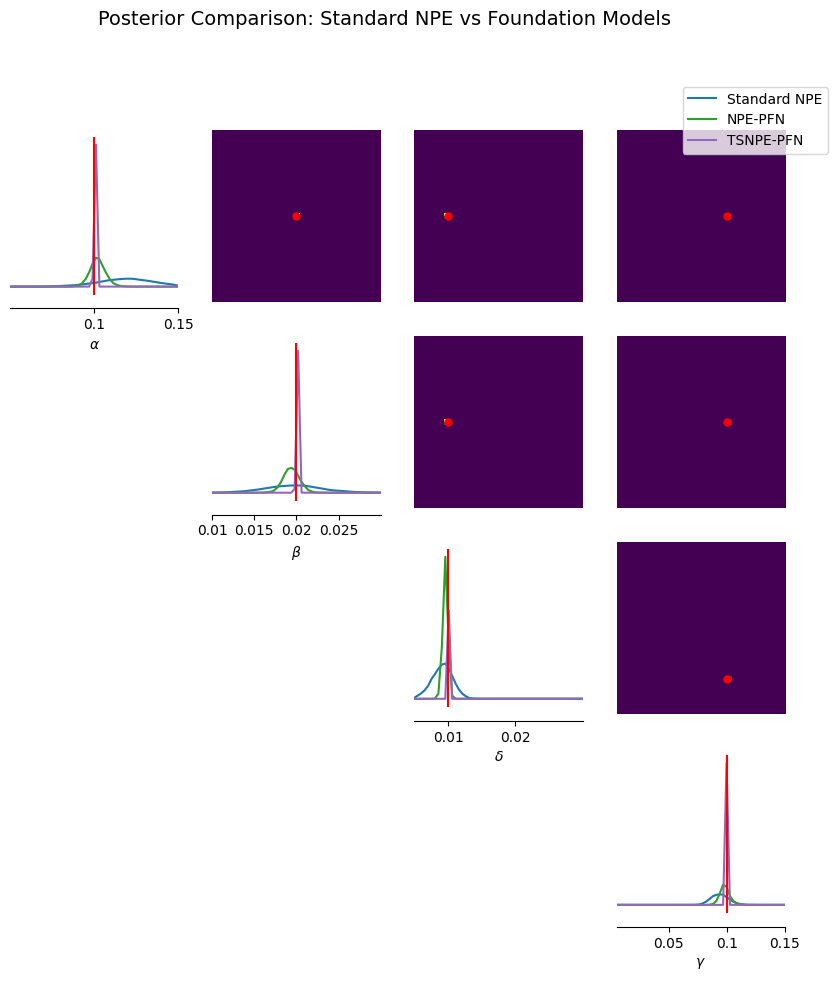

In [8]:
# Compare posteriors with pairplot
param_labels = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]
limits = [[0.05, 0.15], [0.01, 0.03], [0.005, 0.03], [0.005, 0.15]]

fig, axes = pairplot(
    [samples_npe, samples_pfn, samples_tsnpepfn],
    limits=limits,
    labels=param_labels,
    figsize=(10, 10),
    points=theta_o,
    points_colors="red",
    diag="kde",
)

# Add legend
fig.legend(
    ["Standard NPE", "NPE-PFN", "TSNPE-PFN"],
    loc="upper right",
    bbox_to_anchor=(0.95, 0.95),
)
plt.suptitle("Posterior Comparison: Standard NPE vs Foundation Models", y=1.02, fontsize=14)
plt.show()

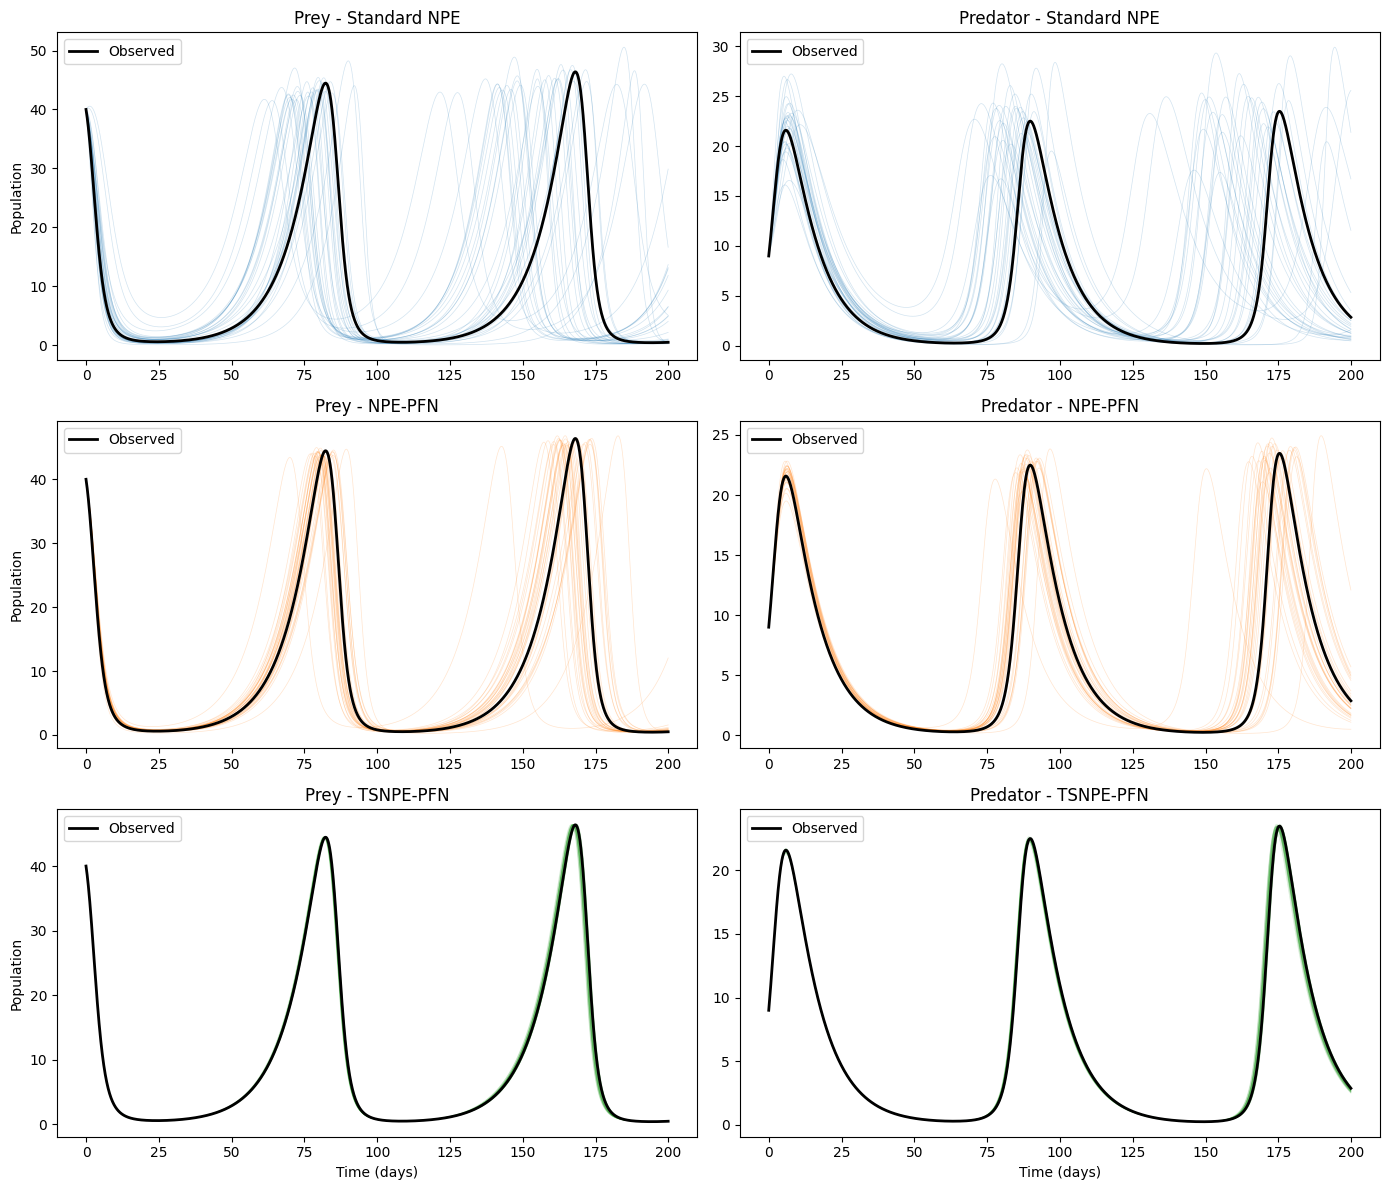

In [9]:
# Posterior Predictive Check for all methods
def plot_posterior_predictive_comparison(samples_list, labels, theta_o, ts_observed, time, n_samples=30):
    """Compare posterior predictive simulations for multiple methods."""
    fig, axes = plt.subplots(len(samples_list), 2, figsize=(14, 4*len(samples_list)))

    colors = ["C0", "C1", "C2"]

    for row, (samples, label, color) in enumerate(zip(samples_list, labels, colors)):
        indices = np.random.choice(len(samples), size=n_samples, replace=False)

        for idx in indices:
            theta_sample = samples[idx].numpy()
            ts_sample = simulate(theta_sample)
            axes[row, 0].plot(time, ts_sample[:, 0], color=color, alpha=0.2, linewidth=0.5)
            axes[row, 1].plot(time, ts_sample[:, 1], color=color, alpha=0.2, linewidth=0.5)

        # Plot ground truth
        axes[row, 0].plot(time, ts_observed[:, 0], color="black", linewidth=2, label="Observed")
        axes[row, 1].plot(time, ts_observed[:, 1], color="black", linewidth=2, label="Observed")

        axes[row, 0].set_ylabel("Population")
        axes[row, 0].set_title(f"Prey - {label}")
        axes[row, 0].legend()

        axes[row, 1].set_title(f"Predator - {label}")
        axes[row, 1].legend()

    axes[-1, 0].set_xlabel("Time (days)")
    axes[-1, 1].set_xlabel("Time (days)")

    plt.tight_layout()
    plt.show()

plot_posterior_predictive_comparison(
    [samples_npe, samples_pfn, samples_tsnpepfn],
    ["Standard NPE", "NPE-PFN", "TSNPE-PFN"],
    theta_o, ts_observed, time
)

---
## Summary

### Methods Comparison

| Method | Training | Simulations | Best For |
|--------|----------|-------------|----------|
| **Standard NPE** | Required (minutes) | Many (1000+) | Production, complex posteriors |
| **NPE-PFN** | None! | Few (100) | Quick prototyping, iteration |
| **TSNPE-PFN** | None! | Few (100) | Single observation, refinement |

### Key Takeaways

1. **Foundation models skip training**: NPE-PFN gives posteriors instantly using in-context learning
2. **Trade-offs exist**: Foundation models may be less flexible than trained models for complex problems
3. **Sequential variants help**: TSNPE-PFN focuses simulations for better efficiency
4. **Great for prototyping**: Try NPE-PFN first, then train a custom model if needed


**Further reading**: [NPE-PFN paper](https://arxiv.org/abs/2504.17660) | [GitHub repository](https://github.com/mackelab/npe-pfn)

---
## Learning Goals

After this notebook, you should be able to:

- ✅ Explain what foundation models are and why they're useful for SBI
- ✅ Use NPE-PFN for instant posterior estimation without training
- ✅ Apply TSNPE-PFN for sequential, observation-focused inference
- ✅ Compare foundation models with standard NPE approaches